## Graph used in both examples

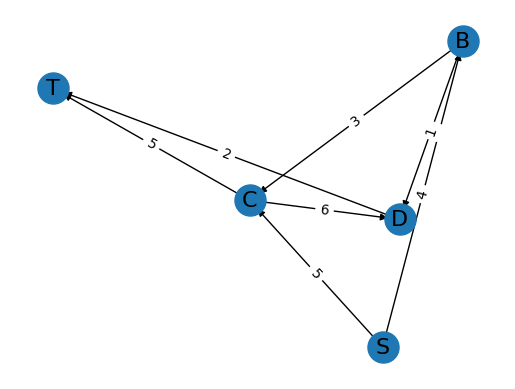

In [26]:
import networkx as nx
import matplotlib.pyplot as plt

supply_dict = {'S': 5, 'B': 2, 'C': 0, 'D': -2, 'T': -5}
combined_list = [str(key) + ':' + str(value) for key, value in supply_dict.items()]

# Define the graph
G = nx.DiGraph()

# Add the vertices
G.add_nodes_from(['S', 'B', 'C', 'D', 'T'])

# Add the edges and weights
G.add_edge('S', 'B', weight=4)
G.add_edge('S', 'C', weight=5)
G.add_edge('B', 'C', weight=3)
G.add_edge('B', 'D', weight=1)
G.add_edge('C', 'D', weight=6)
G.add_edge('C', 'T', weight=5)
G.add_edge('D', 'T', weight=2)


# nx.relabel_nodes(G, dict(zip(['S', 'B', 'C', 'D', 'T'], combined_list)), copy=False)

# Draw the graph
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, width=1, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})
nx.draw_networkx_labels(G, pos, font_size=16, font_family='sans-serif')
plt.axis('off')
plt.show()


## Minimum Cost Problem

In [27]:
from pyomo.environ import *

# Define the directed graph G = (V, E)
model = ConcreteModel()
model.vertices = Set(initialize=['S', 'B', 'C', 'D', 'T'])
model.edges = Set(initialize=[('S', 'B'), ('S', 'C'), ('B', 'C'), ('B', 'D'), ('C', 'D'), ('C', 'T'), ('D', 'T')])

# Define the non-negative edge capacities 
model.capacity = Param(model.edges, initialize={('S', 'B'): 4, ('S', 'C'): 5, ('B', 'C'): 3, ('B', 'D'): 1, ('C', 'D'): 6, ('C', 'T'): 5, ('D', 'T'): 2})

# Define the edge costs 
model.costs = Param(model.edges, initialize={('S', 'B'): 1, ('S', 'C'): 2, ('B', 'C'): 3, ('B', 'D'): 1, ('C', 'D'): 2, ('C', 'T'): 4, ('D', 'T'): 3})

# Define the supply/demand on each vertex (negative value represents demand)
model.supply = Param(model.vertices, initialize={'S': 5, 'B': 2, 'C': 0, 'D': -2, 'T': -5})

# Define the decision variables
model.f = Var(model.edges, within=NonNegativeReals)

# Define the objective function
model.obj = Objective(expr=sum(model.costs[(v, w)] * model.f[(v, w)] for (v, w) in model.edges), sense=minimize)

# Define the constraints
model.flow_balance = ConstraintList()
for v in model.vertices:
    model.flow_balance.add(sum(model.f[(v, w)] for w in model.vertices if (v, w) in model.edges) - sum(model.f[(w, v)] for w in model.vertices if (w, v) in model.edges) == model.supply[v])

model.capacity_limit = ConstraintList()
for (v, w) in model.edges:
    model.capacity_limit.add(model.f[(v, w)] <= model.capacity[(v, w)])

# Initialize the variables
for (v, w) in model.edges:
    model.f[(v, w)].value = 0

# Solve the problem
solver = SolverFactory('glpk')
solver.solve(model)

# Print the results
print('Minimum cost:', model.obj())
for (v, w) in model.edges:
    print(f'Flow from {v} to {w}: {model.f[(v, w)].value}')


Minimum cost: 36.0
Flow from S to B: 0.0
Flow from S to C: 5.0
Flow from B to C: 1.0
Flow from B to D: 1.0
Flow from C to D: 1.0
Flow from C to T: 5.0
Flow from D to T: 0.0


## Maximum flow problem

In [29]:
# Define the directed graph G = (V, E)
model = ConcreteModel()
model.vertices = Set(initialize=['S', 'B', 'C', 'D', 'T'])
model.edges = Set(initialize=[('S', 'B'), ('S', 'C'), ('B', 'C'), ('B', 'D'), ('C', 'D'), ('C', 'T'), ('D', 'T')])

# Define the non-negative edge capacities 
model.capacity = Param(model.edges, initialize={('S', 'B'): 4, ('S', 'C'): 5, ('B', 'C'): 3, ('B', 'D'): 1, ('C', 'D'): 6, ('C', 'T'): 5, ('D', 'T'): 2})

# Define the decision variables
model.f = Var(model.edges, within=NonNegativeReals)

# Define the objective function
# the total flow out of the source node minus the total flow flowing in the source node
model.obj = Objective(expr=sum(model.f[(v, w)] for (v, w) in model.edges if v == 'S') - sum(model.f[(v, w)] for (v, w) in model.edges if w == 'S'), sense=maximize)

# Define the constraints
model.flow_balance = ConstraintList()
for v in model.vertices:
    # the net flow from a node is zero, except for the source and target node
    if v != 'S' and v != 'T':
        model.flow_balance.add(sum(model.f[(v, w)] for w in model.vertices if (v, w) in model.edges) - sum(model.f[(w, v)] for w in model.vertices if (w, v) in model.edges) == 0)
   
model.capacity_limit = ConstraintList()
for (v, w) in model.edges:
    model.capacity_limit.add(model.f[(v, w)] <= model.capacity[(v, w)])

# Initialize the variables
for (v, w) in model.edges:
    model.f[(v, w)].value = 0

# Solve the problem
solver = SolverFactory('glpk')
solver.solve(model)

# Print the results
print(f'The maximum flow is **{model.obj()}**.')
for (v, w) in model.edges:
    print(f'Flow from {v} to {w}: **{model.f[(v, w)].value}**')


The maximum flow is **7.0**.
Flow from S to B: **2.0**
Flow from S to C: **5.0**
Flow from B to C: **2.0**
Flow from B to D: **0.0**
Flow from C to D: **2.0**
Flow from C to T: **5.0**
Flow from D to T: **2.0**


linear_classifiers_student.ipynb  transportation_activation_pyomo.ipynb
TP_original.log			  transportation_problem.ipynb
TP_original.lp			  transportation_problem_original_MILP.py
TP_originl.log			  transportation_pyomo.py
